In [172]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
import scipy.optimize as opt 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import *
from rdd import rdd
from datetime import timedelta
import warnings
sns.set(style="whitegrid")
color = sns.color_palette()[5]

# Function to plot results
def make_plot(df,thresh,o):
    df1 = df[df['threshold']==False]
    df2 = df[df['threshold']!=False]
    
    fig, ax = plt.subplots()
    sns.regplot(x = df1['day_count'], y = df1['total_daily_cases'],order=o)
    sns.regplot(x = df2['day_count'], y = df2['total_daily_cases'],order=o)
    plt.axvline(x=thresh, ls='--',color='gray');
    

In [173]:
covid_master = pd.read_csv('./resources/Covid_data.csv')
covid_df = covid_master.copy()

# Rename Moyenne mobile column
covid_df = covid_df.rename(columns={'Moyenne mobile (7 jours)':'moving_mean_7_days',
                                    'Date de déclaration du cas':'declare_date'})

# Same date stuff
covid_df['declare_date'] = pd.to_datetime(covid_df['declare_date']).dt.normalize()

# Create total_cases column
covid_df['total_daily_cases'] = covid_df['Par lien épidémiologique'] + covid_df['En laboratoire']

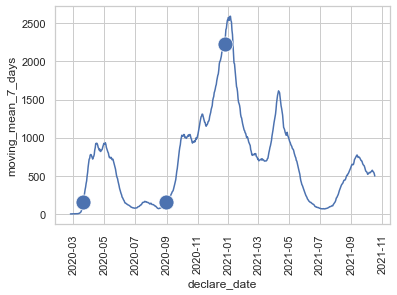

In [174]:
# View data and key dates
sns.lineplot(data=covid_df, x='declare_date', y='moving_mean_7_days', markersize=15,
             marker='o', markevery=[25,189,305])
plt.xticks(rotation='vertical')
plt.show()

In [175]:
# Subset data 
mar20_df = covid_df[0:66].reset_index(drop=True)
aug31_df = covid_df[159:220].reset_index(drop=True)
dec25_df = covid_df[275:336].reset_index(drop=True)

# Indicate days away from key date
mar20_df['day_count'] = range(0,66)
aug31_df['day_count'] = range(0,61)
dec25_df['day_count'] = range(0,61)

In [ ]:
'''
For each event, we used the date range that allowed for the greatest accuracy with a P-value 
less than 0.05.
'''

In [135]:
# Set threshold at day 0 (key date) and create Mar 20 model

march_df = pd.concat((mar20_df['total_daily_cases'], mar20_df['day_count']),axis=1)
y = march_df['total_daily_cases']

march_df['X_squared'] = march_df['day_count']**2
march_df = march_df.assign(threshold=(march_df['day_count'] > 25))

mar_model = smf.ols('y~day_count*threshold', march_df).fit()
poly_model = smf.ols('y~day_count*threshold+X_squared*threshold', march_df).fit()

# Mar linear regression summary
mar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     206.1
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           3.42e-32
Time:                        18:33:54   Log-Likelihood:                -407.38
No. Observations:                  66   AIC:                             822.8
Df Residuals:                      62   BIC:                             831.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     -17.2308     45.615     -0.378      0.707    -108.414      73.953
threshold[T.True]              49.1149     89.448      0.549      0.585    -129.690     227.920
day_count                       2.5262      3.129      0.807      0.423      -3.729       8.781
day_count:threshold[T.True]    12.4077      3.532      3.512      0.001       5.346      19.469
==============================================================================
Omnibus:                        2.829   Durbin-Watson:                   0.818
Prob(Omnibus):                  0.243   Jarque-Bera (JB):                2.352
Skew:                           0.128   Prob(JB):                        0.309
Kurtosis:                       3.888   Cond. No.                         329.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

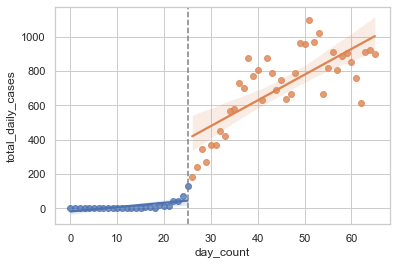

In [169]:
# Mar linear regression plot
make_plot(march_df,25, 1)

In [176]:
# Mar quared polynomial regression summary
poly_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     240.7
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           2.42e-38
Time:                        18:46:10   Log-Likelihood:                -385.86
No. Observations:                  66   AIC:                             783.7
Df Residuals:                      60   BIC:                             796.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      14.6954     47.924      0.307      0.760     -81.167     110.558
threshold[T.True]           -1647.0487    237.669     -6.930      0.000   -2122.458   -1171.640
day_count                      -5.4554      8.877     -0.615      0.541     -23.213      12.302
day_count:threshold[T.True]    98.5749     13.886      7.099      0.000      70.799     126.351
X_squared                       0.3193      0.343      0.931      0.356      -0.367       1.005
X_squared:threshold[T.True]    -1.1784      0.362     -3.253      0.002      -1.903      -0.454
==============================================================================
Omnibus:                        4.754   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.896
Skew:                          -0.283   Prob(JB):                       0.0864
Kurtosis:                       4.208   Cond. No.                     5.94e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

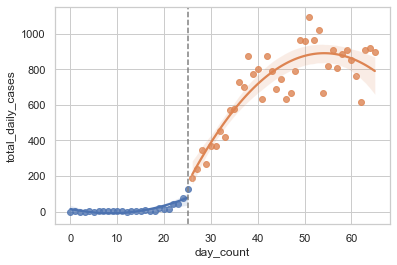

In [170]:
# Mar squared polynomial regression plot
make_plot(march_df,25, 2)

In [ ]:
'''
The 1st Event (20/3/2020 lockdown): Due to data limitations and the fact that the event occurred at the 
beginning of the pandemic, we used 10 days before and after the event date of March 20th, 2020. 
We found this to yield the most accurate predictive results.
'''

'''
We found that a squared polynomial regression model for the March 20th event was sufficient because it 
provided the best fit for the curve we saw in the data. This is confirmed by our high R-squared value.

Following the event date, we saw a sharp increase in Covid-19 cases, as can be seen by the 98.5749
coefficient in our model summary. The p-value of the lockdown cut-off was below 0.05, indicating that 
was a statistically significant event.

After around 14-15 days, the effect of the lockdown can be seen as the number of cases begins to 
plateau. Another reason for the initial rise in cases was likely because of an increase in testing
for the virus.
'''

In [118]:
# Set threshold at day 0 (key date) and create Aug 31 model
aug_df = pd.concat((aug31_df['total_daily_cases'], aug31_df['day_count']),axis=1)
y = aug_df['total_daily_cases']

aug_df['X_squared'] = aug_df['day_count']**2
aug_df = aug_df.assign(threshold=(aug_df['day_count'] > 30))

aug_model = smf.ols('y~day_count*threshold', aug_df).fit()
poly_model = smf.ols('y~day_count*threshold+X_squared*threshold', aug_df).fit()

# Aug linear regression summary
aug_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     251.9
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           7.58e-33
Time:                        18:24:11   Log-Likelihood:                -344.20
No. Observations:                  61   AIC:                             696.4
Df Residuals:                      57   BIC:                             704.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     106.0786     24.771      4.282      0.000      56.476     155.681
threshold[T.True]            -978.0319     73.319    -13.339      0.000   -1124.851    -831.213
day_count                      -0.4117      1.418     -0.290      0.773      -3.252       2.429
day_count:threshold[T.True]    29.4722      2.057     14.327      0.000      25.353      33.591
==============================================================================
Omnibus:                        0.840   Durbin-Watson:                   0.381
Prob(Omnibus):                  0.657   Jarque-Bera (JB):                0.283
Skew:                           0.048   Prob(JB):                        0.868
Kurtosis:                       3.320   Cond. No.                         382.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

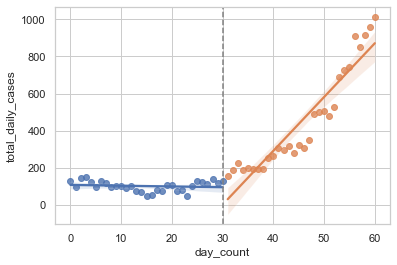

In [182]:
# Aug linear regression plot
make_plot(aug_df,30,1)

In [116]:
# Aug squared polynomial regression summary
poly_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     46.77
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           1.33e-18
Time:                        18:24:06   Log-Likelihood:                -408.23
No. Observations:                  61   AIC:                             828.5
Df Residuals:                      55   BIC:                             841.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1290.7148    103.908     12.422      0.000    1082.479    1498.951
threshold[T.True]           -2094.4952   1141.264     -1.835      0.072   -4381.640     192.650
day_count                      31.1293     16.032      1.942      0.057      -1.000      63.259
day_count:threshold[T.True]   150.1732     53.653      2.799      0.007      42.649     257.697
X_squared                       0.1059      0.516      0.205      0.838      -0.929       1.141
X_squared:threshold[T.True]    -2.5953      0.762     -3.405      0.001      -4.123      -1.068
==============================================================================
Omnibus:                        0.832   Durbin-Watson:                   1.132
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.496
Skew:                           0.218   Prob(JB):                        0.780
Kurtosis:                       3.067   Cond. No.                     9.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

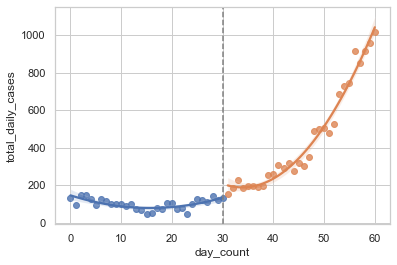

In [181]:
# Aug squared polynomial regression plot
make_plot(aug_df,30,2)

In [ ]:
'''
We found that a squared polynomial regression model for the Aug 31st event was a better choice than a
linear model because it resulted in a higher R-squared value. 

Following the reopening of schools, we saw an sharp increase in Covid-19 cases; this is shown by the 
150.1732 coefficient in our model summary. Since the p-value for the threshold was below 0.05, we 
concluded that the event was statistically significant.

Unlike in March, the cases continued to rise. This indicates a strong correllation between the return to 
school and the spread of Covid-19
'''

In [103]:
# Set threshold at day 0 (key date) and create Dec 25 model
dec_df = pd.concat((dec25_df['total_daily_cases'], dec25_df['day_count']),axis=1)
y = dec_df['total_daily_cases']

dec_df['X_squared'] = dec_df['day_count']**2
dec_df = dec_df.assign(threshold=(dec_df['day_count'] > 30))

dec_model = smf.ols('y~day_count*threshold', dec_df).fit()
poly_model = smf.ols('y~day_count*threshold+X_squared*threshold', dec_df).fit()

# Dec linear regression summary
dec_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     54.41
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           9.86e-17
Time:                        18:13:52   Log-Likelihood:                -417.59
No. Observations:                  61   AIC:                             843.2
Df Residuals:                      57   BIC:                             851.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1275.3528     82.501     15.459      0.000    1110.148    1440.558
threshold[T.True]            2888.0554    244.193     11.827      0.000    2399.067    3377.044
day_count                      34.3077      4.724      7.262      0.000      24.848      43.767
day_count:threshold[T.True]   -79.5408      6.851    -11.610      0.000     -93.260     -65.821
==============================================================================
Omnibus:                        5.485   Durbin-Watson:                   0.972
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                7.638
Skew:                           0.110   Prob(JB):                       0.0219
Kurtosis:                       4.719   Cond. No.                         382.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

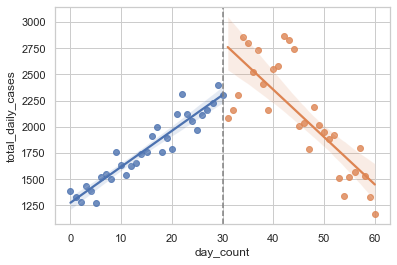

In [180]:
# Dec linear regression plot
make_plot(dec_df,30,1)

In [104]:
# Dec squared polynomial regression summary
poly_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     46.77
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           1.33e-18
Time:                        18:14:00   Log-Likelihood:                -408.23
No. Observations:                  61   AIC:                             828.5
Df Residuals:                      55   BIC:                             841.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1290.7148    103.908     12.422      0.000    1082.479    1498.951
threshold[T.True]           -2094.4952   1141.264     -1.835      0.072   -4381.640     192.650
day_count                      31.1293     16.032      1.942      0.057      -1.000      63.259
day_count:threshold[T.True]   150.1732     53.653      2.799      0.007      42.649     257.697
X_squared                       0.1059      0.516      0.205      0.838      -0.929       1.141
X_squared:threshold[T.True]    -2.5953      0.762     -3.405      0.001      -4.123      -1.068
==============================================================================
Omnibus:                        0.832   Durbin-Watson:                   1.132
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.496
Skew:                           0.218   Prob(JB):                        0.780
Kurtosis:                       3.067   Cond. No.                     9.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

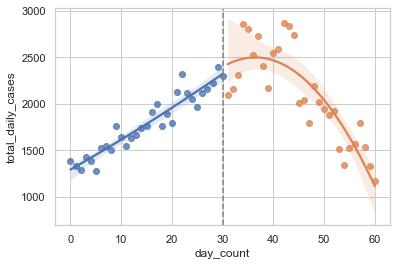

In [179]:
# Dec squared polynomial regression plot
make_plot(dec_df,30,2)

In [177]:
'''
The 2nd and 3rd Events (31/8 School Resumes, 25/12 lockdown): We used 30 days before and after the event 
date. This was to ensure that an accurate snapshot of case totals was provided. 
Any longer periods would risk interference from other events (and affect the accuracy of our predictions).

We note that each range was greater than 10 days. On average, Covid symptoms generally appear within 
5-6 days after infection. Thus, our date ranges are sufficient to capture the impacts of each event.
'''

'''
We found that a squared polynomial regression model for the Christmas lockdown was the best fit again.
This was confirmed by a high R-squared value.

Roughly two weeks after an initial increase, total Covid-19 cases began to drop, indicating that the 
lockdown was effective. The event day's p-value also confirmed these findings.
'''

'\nThe 2nd and 3rd Events (31/8 School Resumes, 25/12 lockdown): We used 30 days before and after the event \ndate. This was to ensure that an accurate snapshot of case totals was provided. \nAny longer periods would risk interference from other events (and affect the accuracy of our predictions).\n\nWe note that each range was greater than 10 days. On average, Covid symptoms generally appear within \n5-6 days after infection. Thus, our date ranges are sufficient to capture the impacts of each event.\n'

In [178]:
'''
Higher polynomials lead to noisy estimates, with more values appearing on the plot that needed causing 
a poor coverage of confidence intervals. Since the RDD estimate is essentially a difference between a 
weighted average of outcomes for either side of the threshold, fitting a high order polynomial can mean 
this weighted average is driven by observations that are far away from the threshold

**Other regression design considerations**

Dates (X-axis), whether to include other features in our analysis (par lien épidémiologique, en 
laboratoire), whether to use moving mean per 7 days or daily case totals.


'\nWe found that a regular linear regression model (to the first degree) for the March 20th and \nDecember 25th lockdown events was sufficient in fitting the data, as the results were more linear \nin nature. However, for the August 31st return to school event, the square polynomial proved to be \nthe best fit, since the results were more curved. We decided not to use any higher degrees in our \nmodels as this could lead to an over-fit of the model which results in a poor estimator for long-range \npredictions. \n\nHigher polynomials lead to noisy estimates, with more values appearing on the plot that needed causing \na poor coverage of confidence intervals. Since the RDD estimate is essentially a difference between a \nweighted average of outcomes for either side of the threshold, fitting a high order polynomial can mean \nthis weighted average is driven by observations that are far away from the threshold\n\n\n**Other regression design considerations** (This needs to be cleaned up, a

In [ ]:
'''
We tried to use functions to produce our models, but ran into an error. We believe it is always calling
on the mar20_df range instead of the longer range when calling the aug31_df and dec25_df dataframes. 

If you can see our mistake, can you let us know where it is?

Thanks!
- group 4
'''

# function model Models

def get_models(df):
#     y = df1['total_daily_cases']
    lin_model = smf.ols('y~day_count*threshold', df).fit()
    

    poly_model = smf.ols('y~day_count*threshold+X_squared*threshold', df).fit()
    print(lin_model.summary())
    print(poly_model.summary())
    
# function to get df's to model
def get_df(df,cut_off):
    df1 = pd.concat((df['total_daily_cases'], df['day_count']),axis=1)
    y = df1['total_daily_cases']
    
    df1['X_squared'] = df1['day_count']**2

    df1 =df1.assign(threshold=(df1['day_count'] > cut_off))
    
    get_models(df1)